In [1]:
import os
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn import set_config

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
def processText(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [3]:
data = pd.read_csv('data/goemotions.csv')
features = data['text'].apply(processText)
labels = data.iloc[:, 9:]

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels.iloc[:, 0]
)

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=15000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    )),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )))
])

set_config(display='diagram')
pipeline


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=15000, min_df=2,
                                 ngram_range=(1, 2), strip_accents='unicode',
                                 sublinear_tf=True)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                        max_depth=20,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=5,
                                                                        n_estimators=200,
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

In [5]:
param_grid = {
    'tfidf__max_features': [10000, 15000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [15, 20],
    'classifier__estimator__min_samples_split': [2, 5],
    'classifier__estimator__min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    error_score='raise'
)

In [16]:
history = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


Training:   0%|          | 0/6 [1:12:25<?, ?it/s]


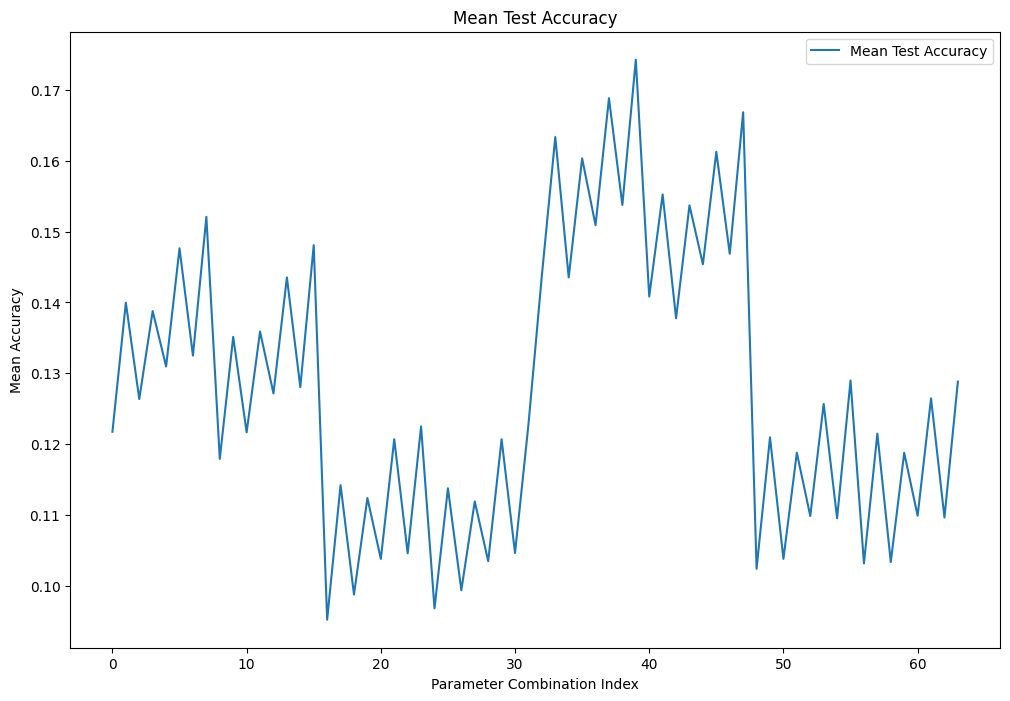

In [17]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 8))
plt.plot(results['mean_test_score'], label='Mean Test Accuracy')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Accuracy')
plt.title('Mean Test Accuracy')
plt.legend()
plt.show()

In [18]:
y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels.columns))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

    admiration       0.39      0.59      0.47      1129
     amusement       0.54      0.68      0.60       626
         anger       0.25      0.43      0.32       534
     annoyance       0.16      0.37      0.23       884
      approval       0.20      0.33      0.25      1212
        caring       0.14      0.33      0.20       380
     confusion       0.14      0.35      0.20       505
     curiosity       0.16      0.24      0.19       615
        desire       0.19      0.45      0.26       240
disappointment       0.13      0.28      0.18       560
   disapproval       0.16      0.40      0.23       787
       disgust       0.17      0.42      0.25       343
 embarrassment       0.11      0.28      0.16       163
    excitement       0.17      0.35      0.23       376
          fear       0.32      0.41      0.36       206
     gratitude       0.68      0.80      0.74       739
         grief       0.

c:\Users\TTill\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TTill\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print("\nEmotion accuracy:")
per_emotion_accuracy = {}
for i, emotion in enumerate(labels.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    per_emotion_accuracy[emotion] = acc
    print(f"{emotion}: {acc:.4f}")


Emotion accuracy:
admiration: 0.8929
amusement: 0.9598
anger: 0.9298
annoyance: 0.8416
approval: 0.8304
caring: 0.9269
confusion: 0.9021
curiosity: 0.9101
desire: 0.9572
disappointment: 0.8966
disapproval: 0.8509
disgust: 0.9371
embarrassment: 0.9659
excitement: 0.9364
fear: 0.9785
gratitude: 0.9698
grief: 0.9942
joy: 0.9381
love: 0.9590
nervousness: 0.9811
optimism: 0.9349
pride: 0.9887
realization: 0.8866
relief: 0.9843
remorse: 0.9841
sadness: 0.9424
surprise: 0.9497
neutral: 0.5852


In [1]:
models = 'models'

parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
path = os.path.join(models, 'sentiment_model.pkl')

with open(path, 'wb') as sentiment_model:
    pickle.dump(grid_search.best_estimator_, sentiment_model)

NameError: name 'os' is not defined